In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
# Importing DataScience libraries
from scipy.stats import norm,skew
from scipy import stats
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.model_selection import cross_val_score
import warnings
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
train = pd.read_csv("/content/train.csv", encoding = "UTF-8")
test = pd.read_csv("/content/test.csv", encoding = "UTF-8")
train_c=train.copy()
test_c=test.copy()

# 1. Exploratory Data Analysis


   



In [4]:
print("Our traning set has the following shape : "+str(train.shape))
print("Our test set has the following shape : "+str(test.shape))

Our traning set has the following shape : (1460, 81)
Our test set has the following shape : (1459, 80)


#### **Type of variables** : 





In [5]:
train.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

#### **Description of the variable**

## **1.2 Checking the missing values**

In [6]:
# Using isnull fuction to count the total null values in each field
total = train.isnull().sum().sort_values(ascending=False) 
# Percent of missing values is estimated by dividing total missing and the original total
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
# Concatenating the Total and Percent fields sing pandas concat fucntion
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# Displays top 20 from our max sorted list
missing_data.head(20)

Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageYrBlt      81  0.055479
GarageCond       81  0.055479
GarageType       81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
BsmtFinType2     38  0.026027
BsmtExposure     38  0.026027
BsmtQual         37  0.025342
BsmtCond         37  0.025342
BsmtFinType1     37  0.025342
MasVnrArea        8  0.005479
MasVnrType        8  0.005479
Electrical        1  0.000685
Id                0  0.000000

In [7]:
train.drop("Id",axis=1,inplace=True)
train.drop(["PoolQC","MiscFeature","Alley","Fence"],axis=1,inplace=True)

## **1.3 Checking ditribution of our target variable and independant variables**

### Target variable

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Log Normal'}, xlabel='SalePrice'>

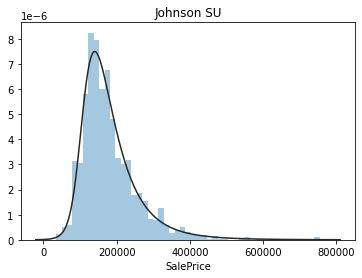

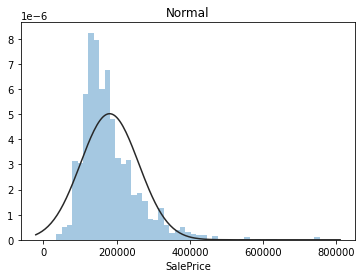

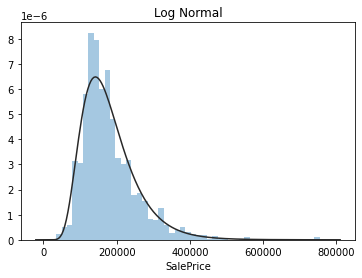

In [8]:
y = train['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

So confirmed by the kstest, our p-value is really inferior to 0.05, so we can reasonably reject the H0 hypothesis and SalePrice is not following a normal distribution.

In [9]:
stats.kstest(np.array(train["SalePrice"]),'norm',args=(train["SalePrice"].mean(),train["SalePrice"].std()))

KstestResult(statistic=0.12368542719946385, pvalue=6.330230702928437e-20, statistic_location=190000, statistic_sign=1)

### Independant variable

Regarding our indepedant variable, we can check the our k-test also to verify that the other variables are not following a normal distribution.

In [10]:
selection=train.select_dtypes(exclude=["object"]).columns

for col in selection:
    df=train[col].dropna(axis=0)
    check_var=np.array(df)
    res=stats.kstest(check_var,'norm',args=(df.mean(),df.std())).pvalue
    if res>=0.05:
        print("This column seems to be normally distirbuted : "+col+" (p_value=)"+res)
print("It's finish")    



It's finish


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

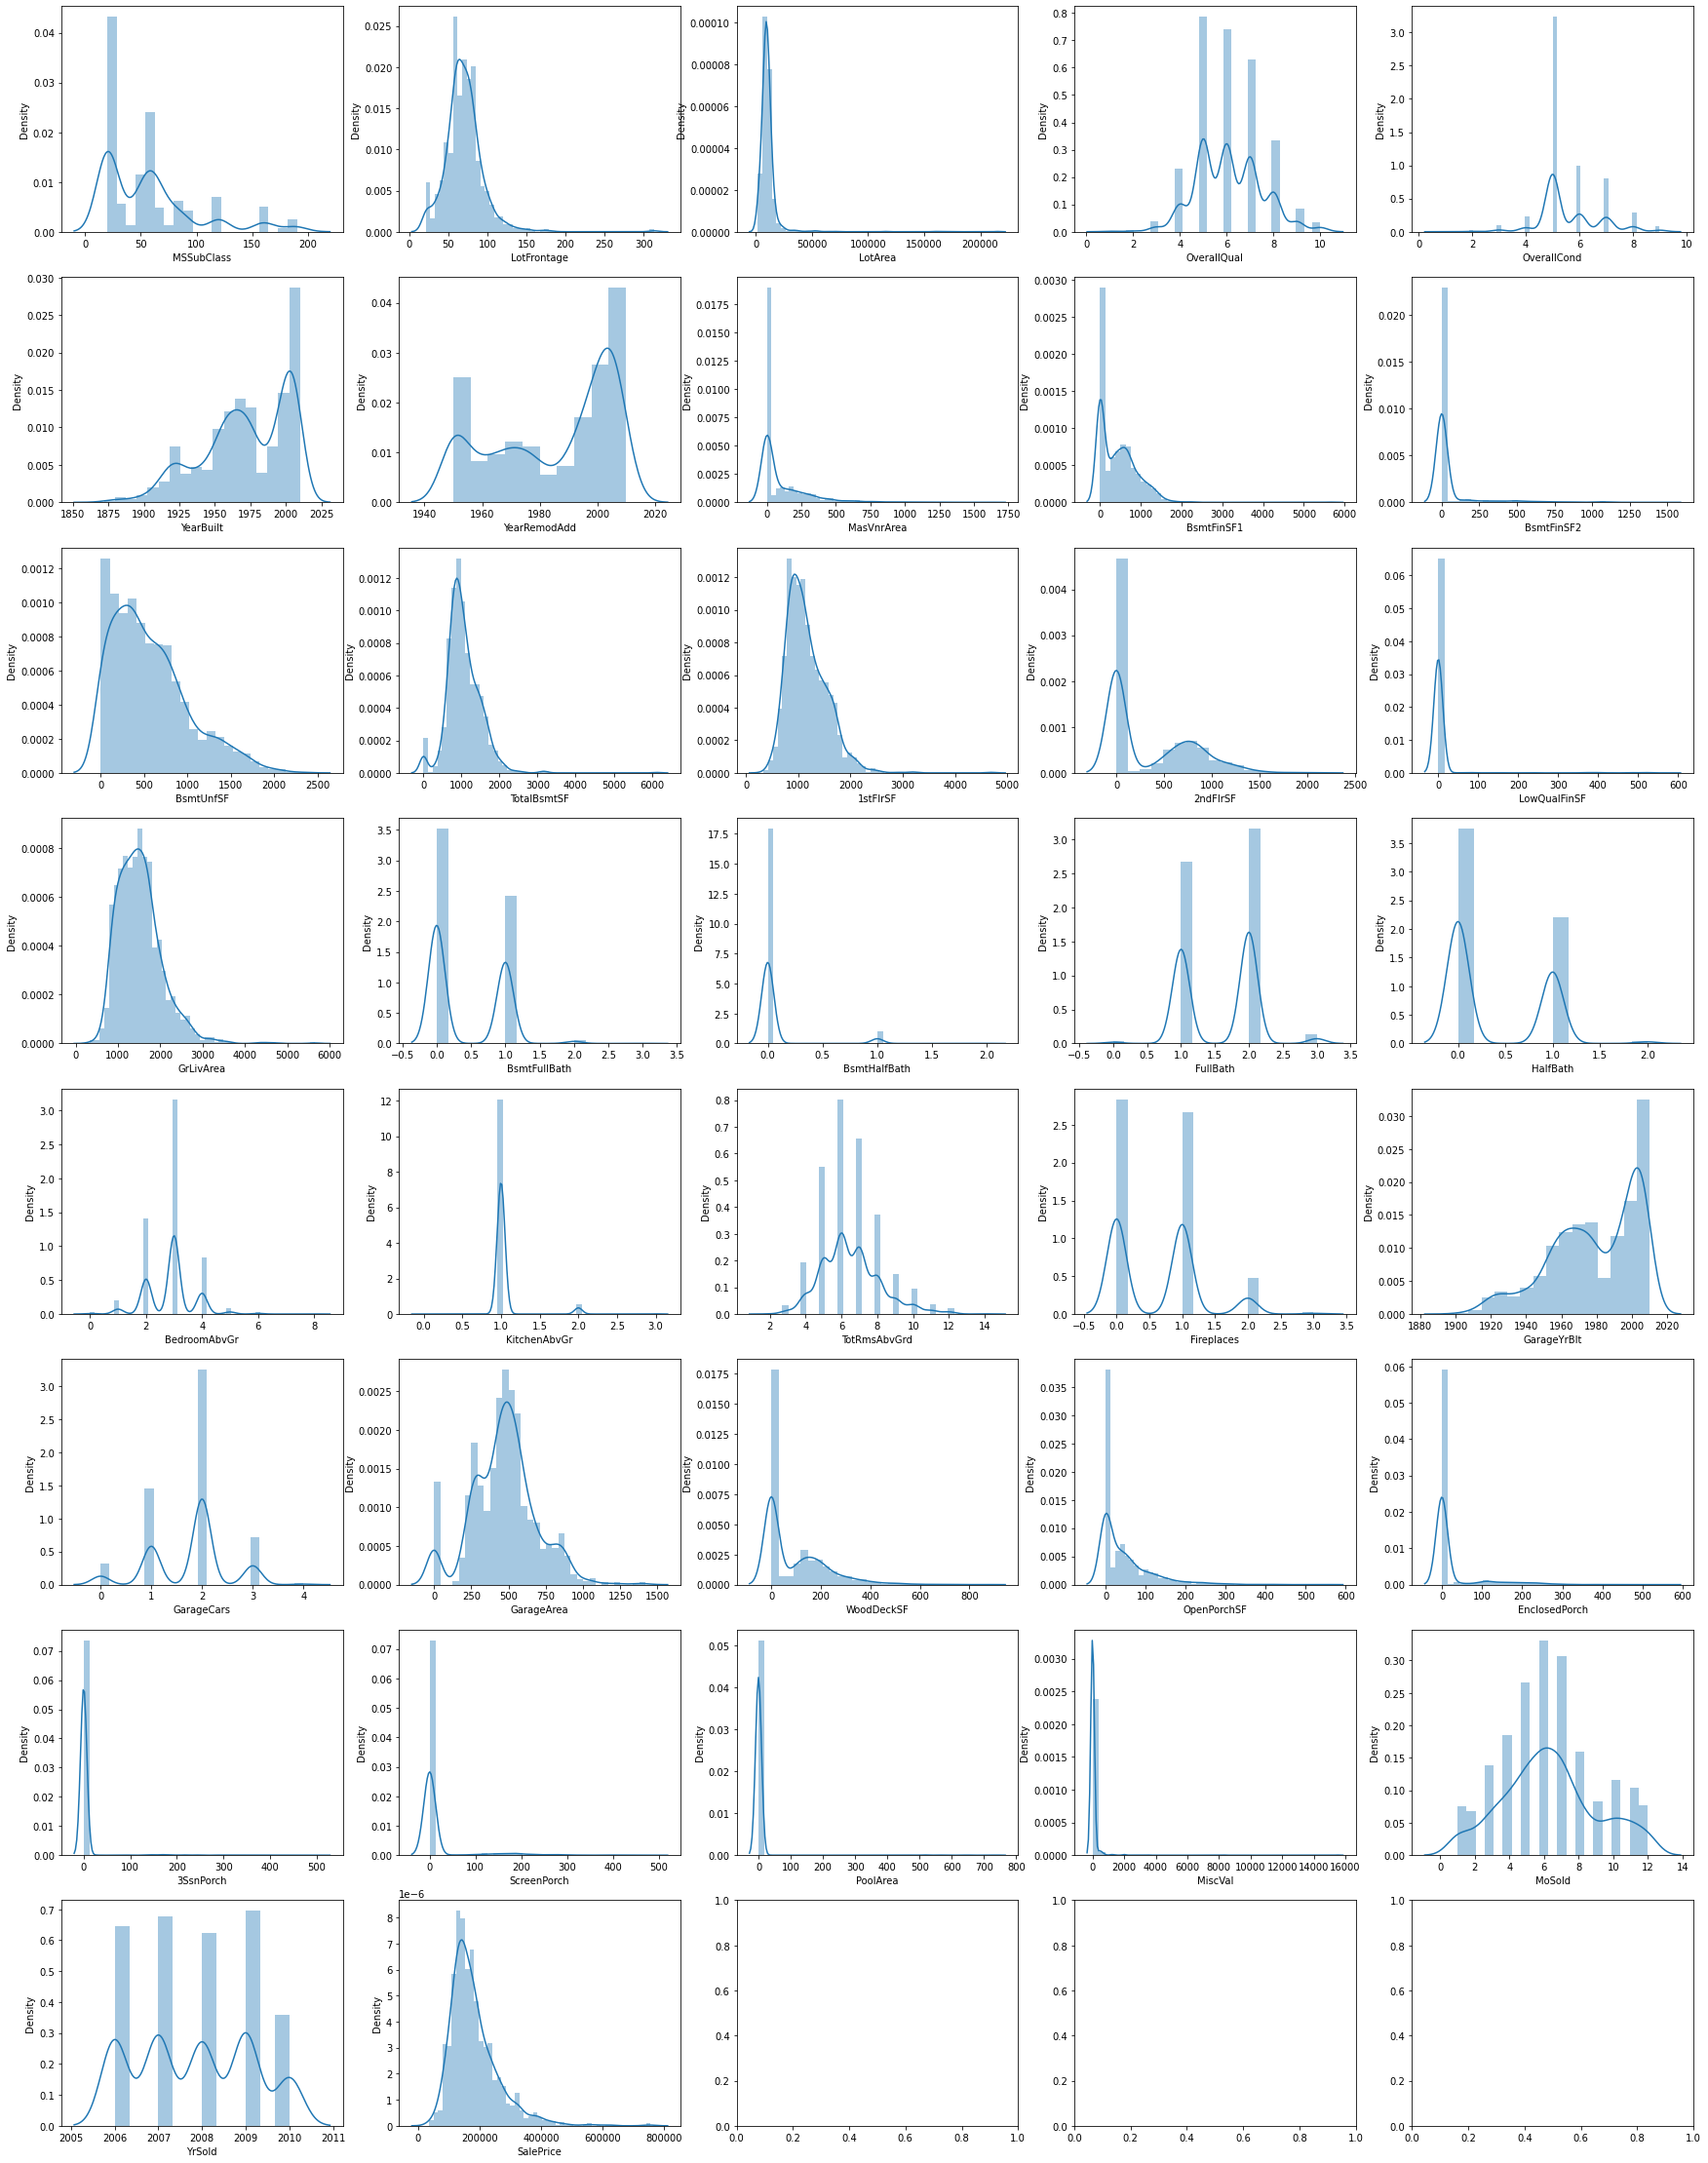

In [11]:
fig,ax = plt.subplots(8,5,figsize=(30,40))
i=0
#matplotlib.rcParams['figure.autolayout'] = False
for col in train.select_dtypes(exclude=['object']):
    #plt.figure() remove the line to avoid the text under the plot !
    #plt.rcParams["figure.figsize"] = (30,40)
    sns.distplot(train[col],ax=ax[i//5,i%5])
    i=i+1



As we can see here, we have also some good client for the log normal distribution. Lot Area, BsmtUnSF, TotalBsmtSF,1stFlrSF,GrLivArea. So we could apply a lognormal transformation after on those different variables.

## **1.4 The relationship between the target variable and the independant variables**

So here we will use the mutual information tool as it represents many different advantages. Indeed, Mutual information (MI) is a non-negative value that measures the mutual dependence between two random variables. The mutual information measures the amount of information we can know from one variable by observing the values of the second variable.

The mutual information is a good alternative to Pearson’s correlation coefficient, because it is able to measure any type of relationship between variables, not just linear associations. And also, it is suitable for both continuous and discrete variables, unlike Pearson’s correlation coefficient.

So first, here we will check this info between the target variables and the independant variables. So we will start our analysis with this.

In [12]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [13]:
mi_info=[]
for col in train.columns:
    t=train[[col,"SalePrice"]].dropna(axis=0)
    if col!="SalePrice":
        mi_score=make_mi_scores(t,t["SalePrice"])
        mi_info.append((col,mi_score[1]))
    else:
        pass
print("Finish")

Finish


<AxesSubplot:xlabel='score_mi', ylabel='feature'>

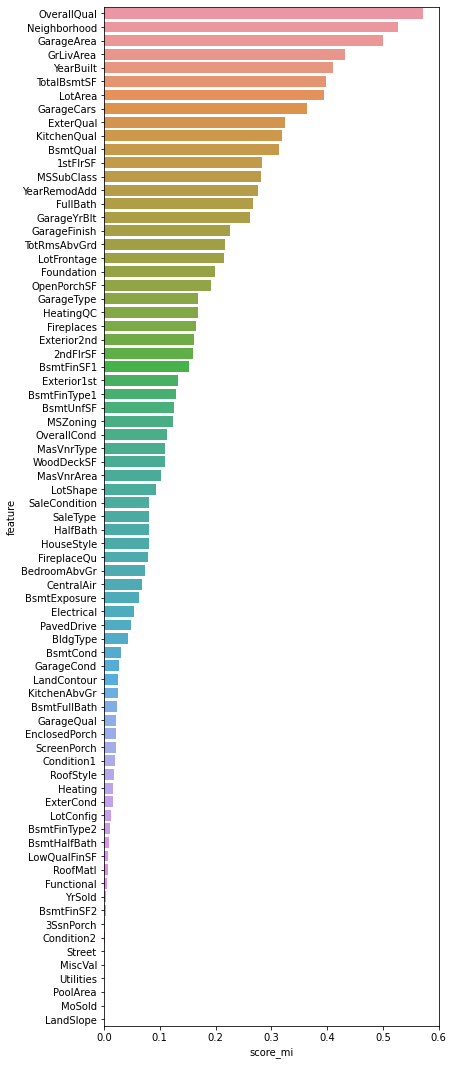

In [14]:
mi_scores=pd.DataFrame(mi_info,columns=["feature","score_mi"]).sort_values(by=['score_mi'],ascending=False)
plt.figure(figsize=(6, 0.25*len(mi_info)))
sns.barplot(data=mi_scores, y='feature', x='score_mi', orient='h')

As we can see, it seems that we have several variables that can be found quite logically :

GrLivArea,GareArea,LotArea, all the variables which are referring to a surfaces.

But we denote also some more interesting insights with the high contribution of the OverallQuall variable and the neighborhood also.


## Violin plot :

It could be also interesting to see in the categorical variables the distributions of SalePrices.

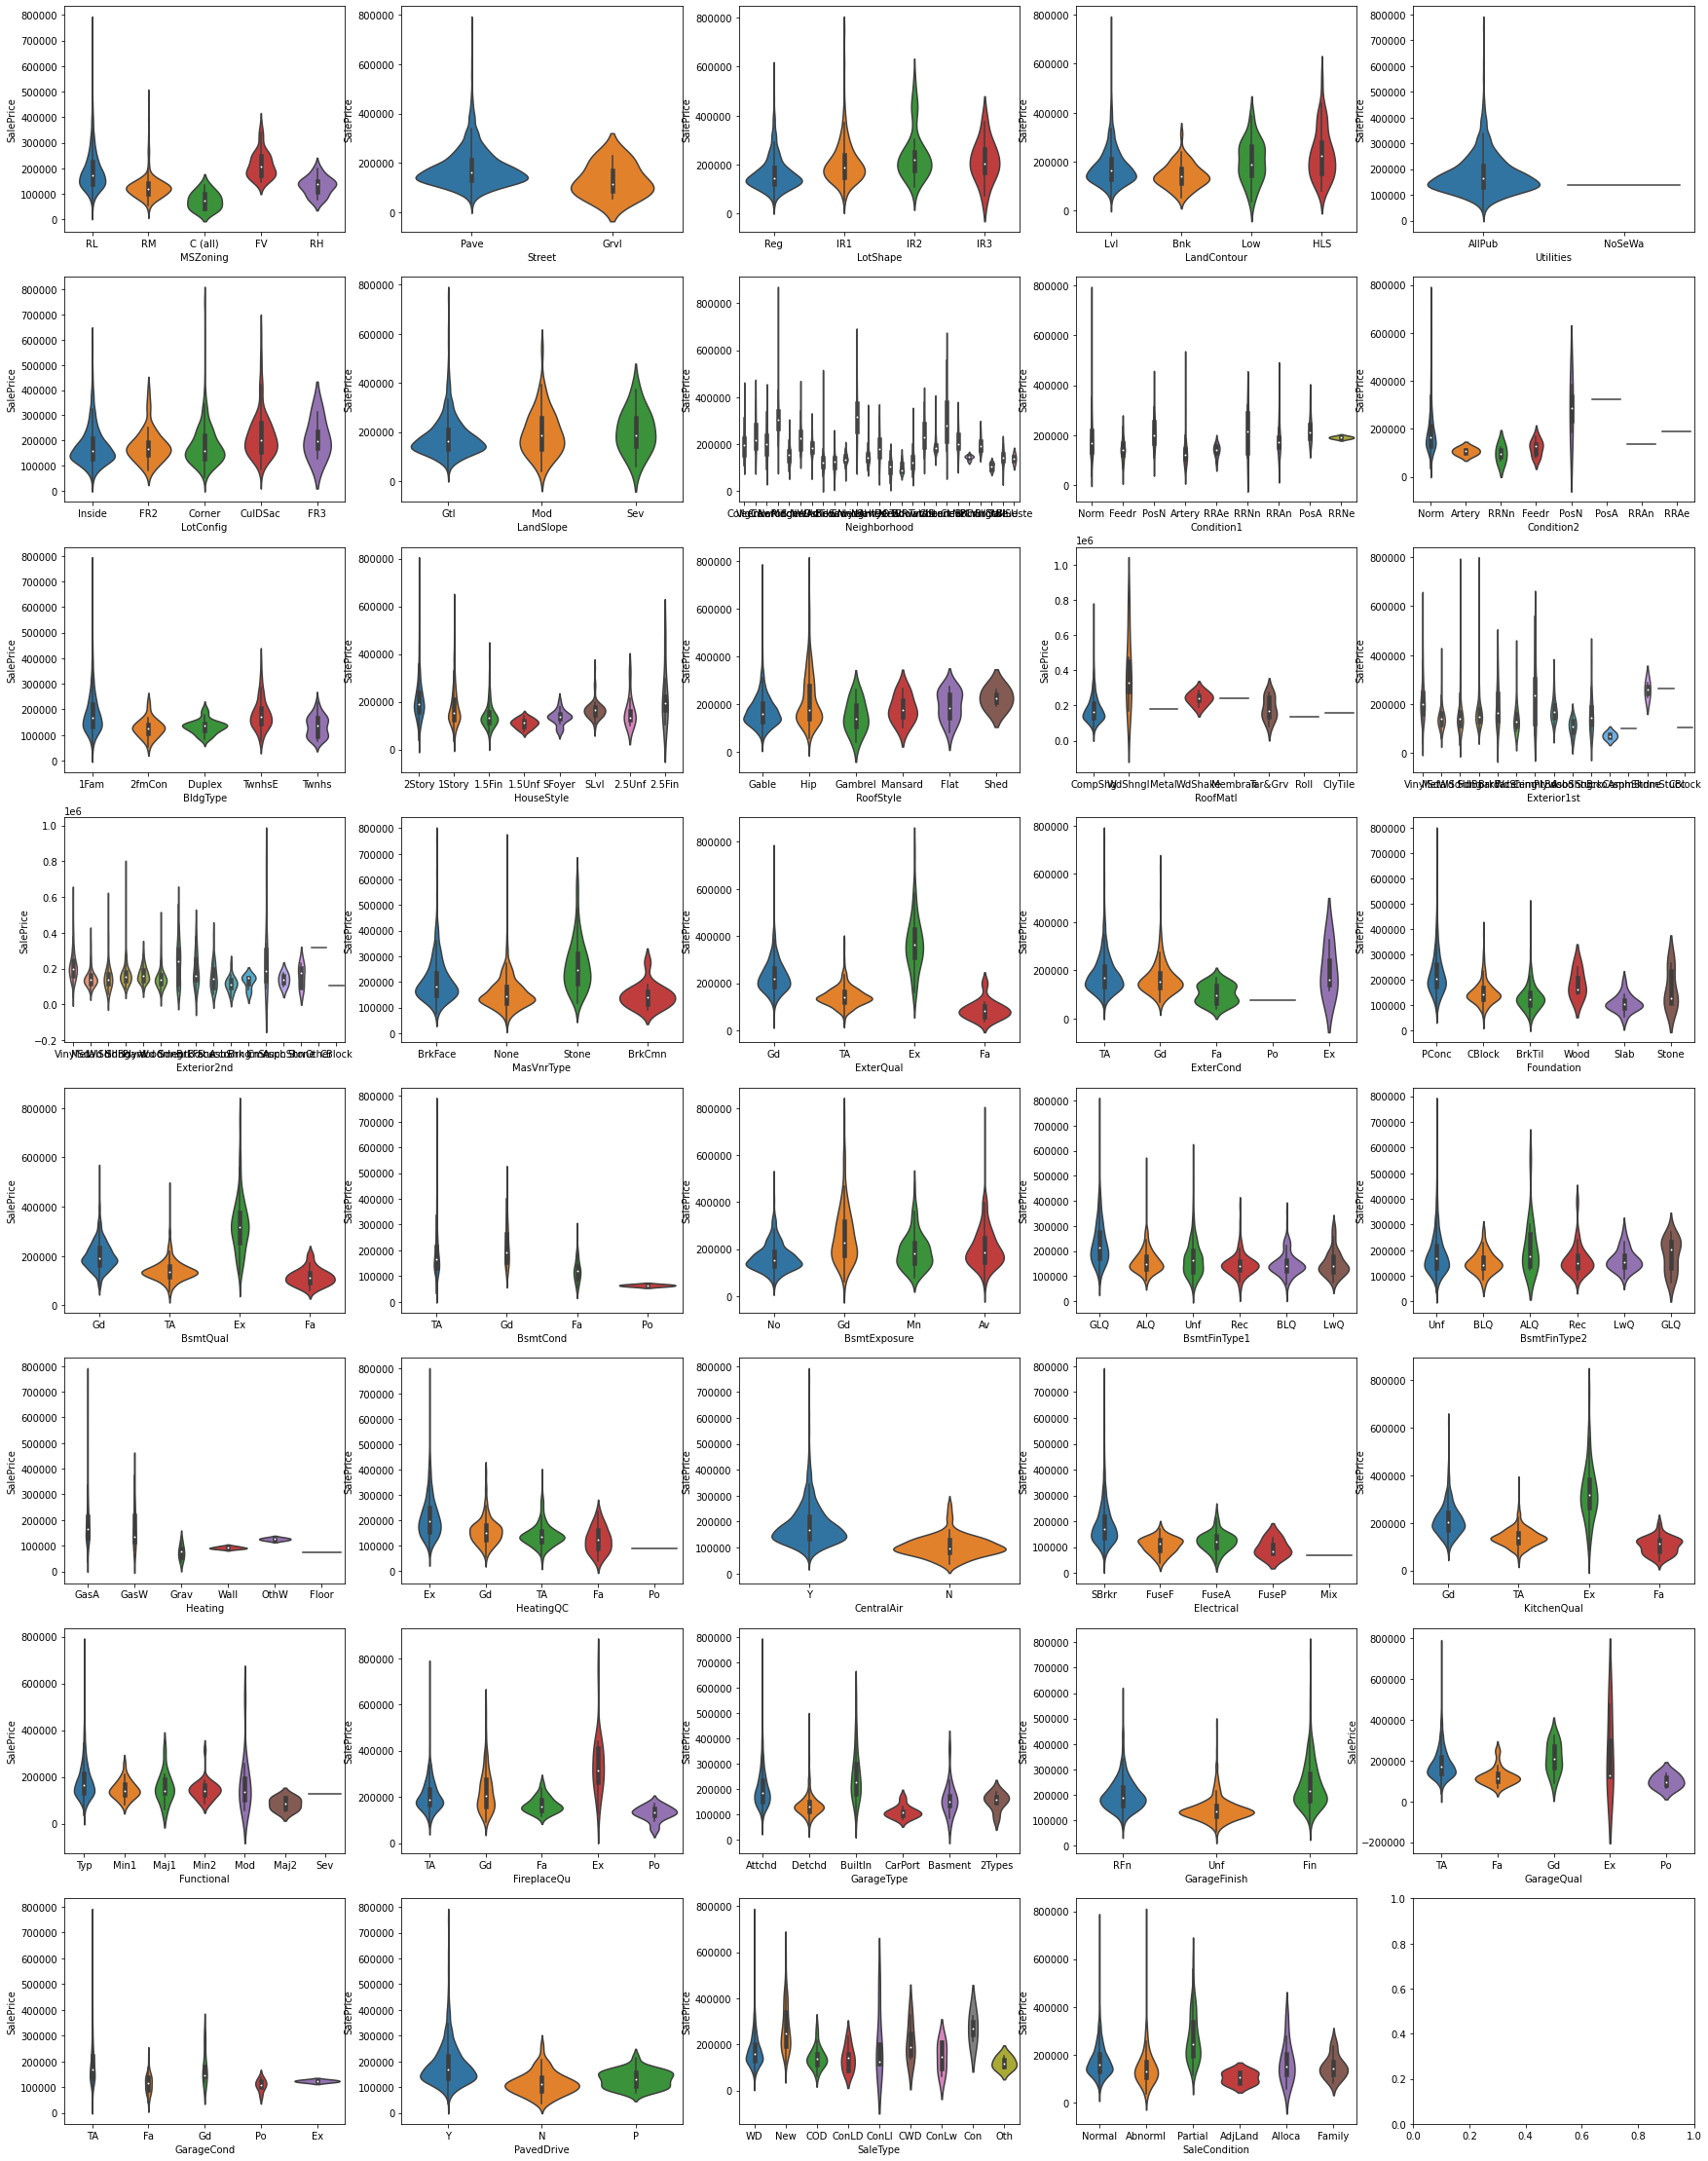

In [15]:
fig,ax = plt.subplots(8,5,figsize=(30,40))
i=0
for col in train.select_dtypes('object'):
    sns.violinplot(data=train,x=train[col],y=train["SalePrice"],ax=ax[i//5,i%5])
    i=i+1

Violin graph are really interesting as it allows us to see the distribution of the variable per category but it's also interesting to the at the same time the range of our numerical variable in this category.

For example here, if we look at the ExterQual variable, we can see that houses with excellent exterior have higher prices than the others and at the same time the distribution of the sales price is more spread out for ExteriorQual==Ex.

## Box plot :

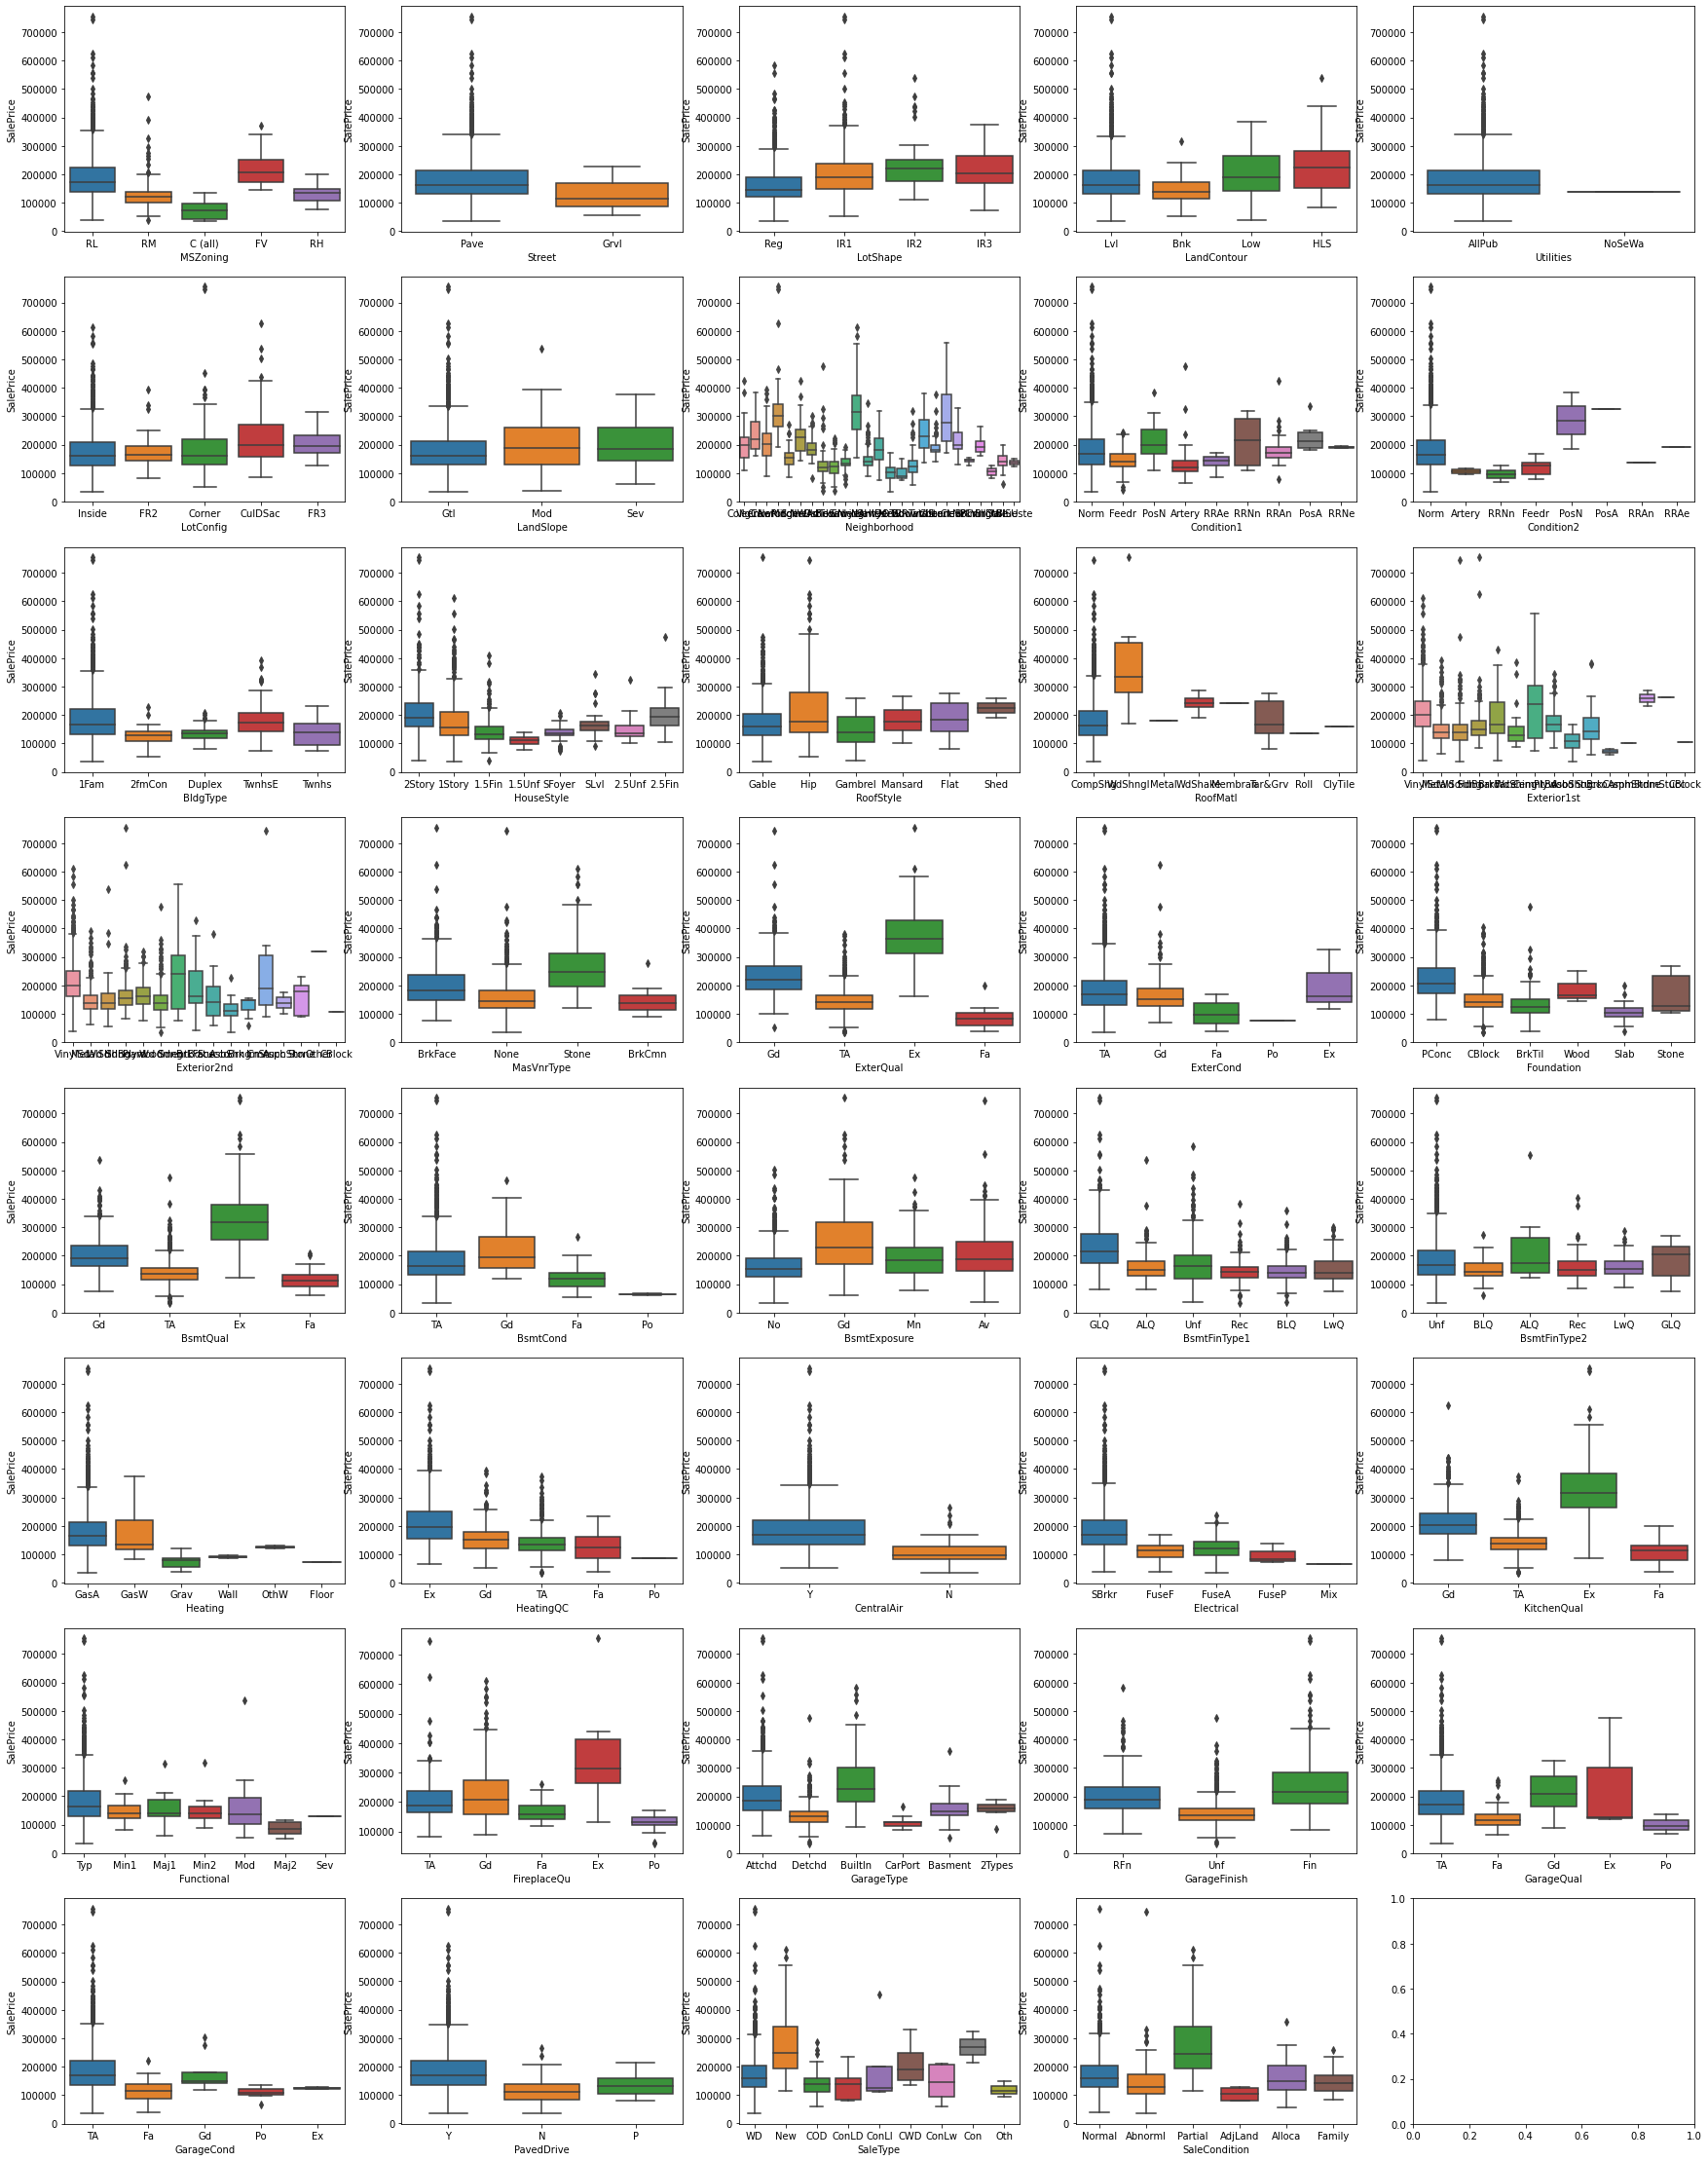

In [16]:
fig,ax = plt.subplots(8,5,figsize=(30,40))
i=0
for col in train.select_dtypes('object'):
    sns.boxplot(data=train,x=train[col],y=train["SalePrice"],ax=ax[i//5,i%5])
    i=i+1

## **1.5 The relationship / interaction the independant variables**

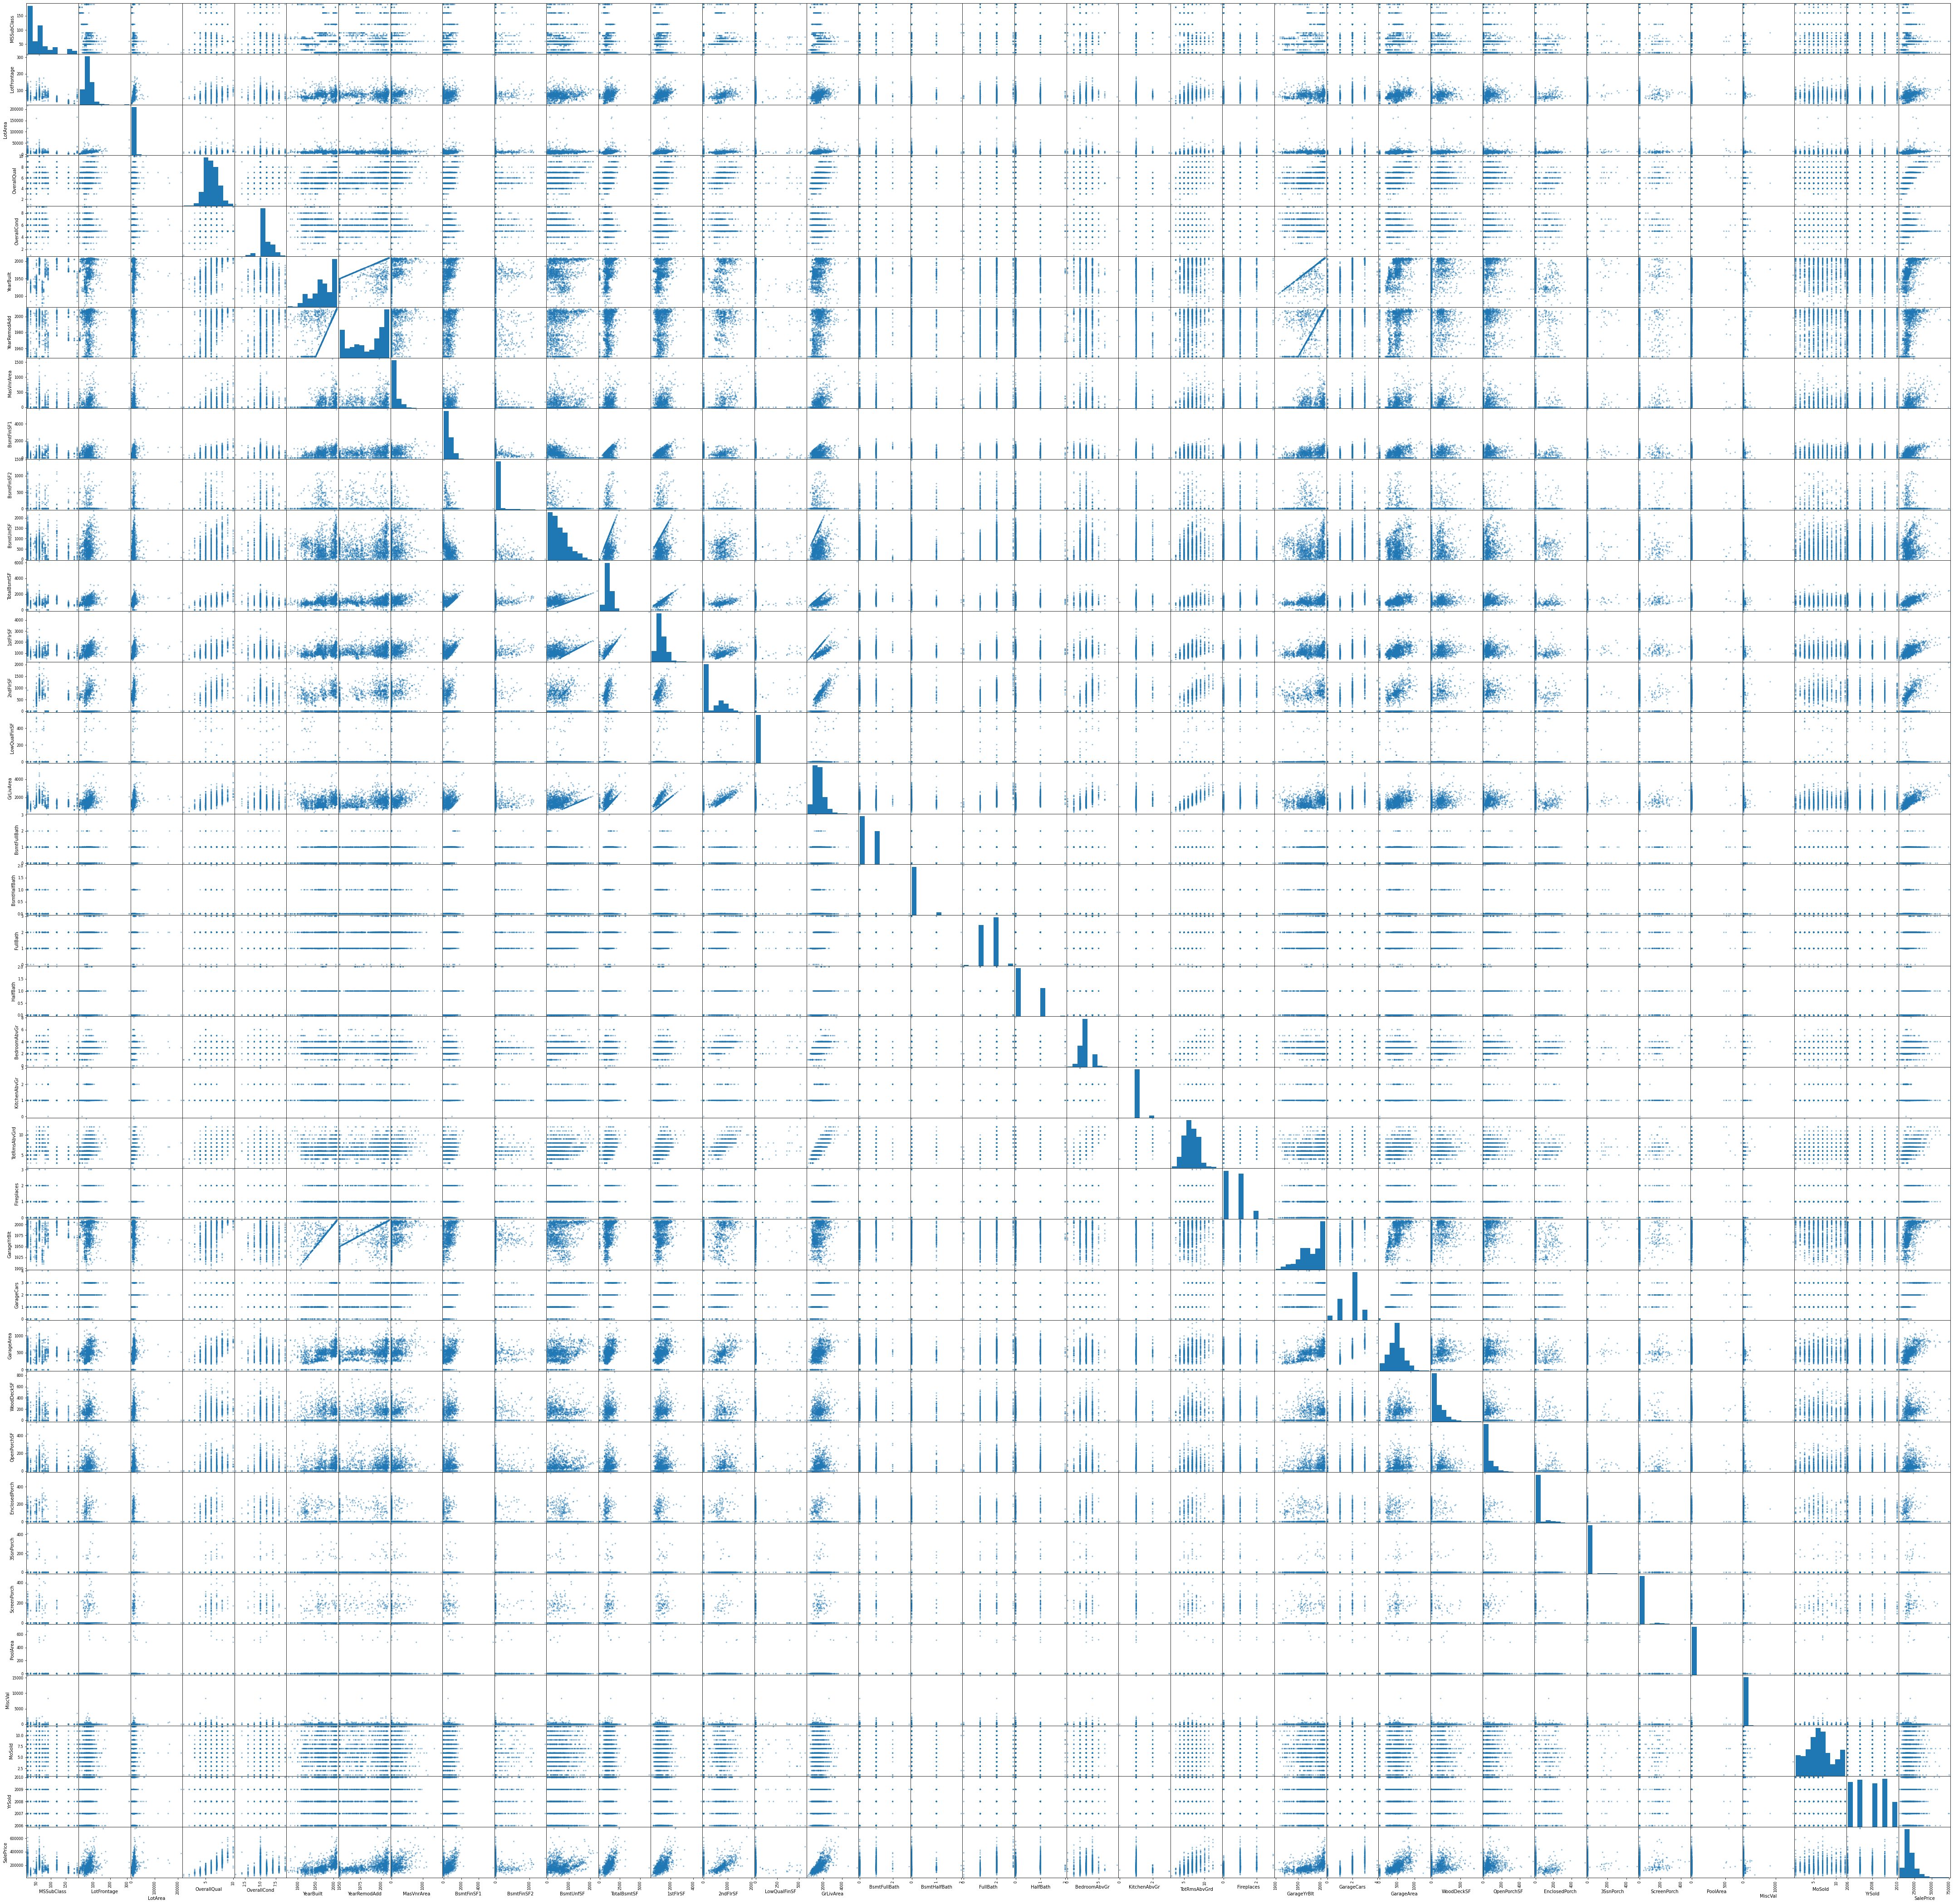

In [17]:
pd.plotting.scatter_matrix(train, figsize=(76, 76))
plt.show()

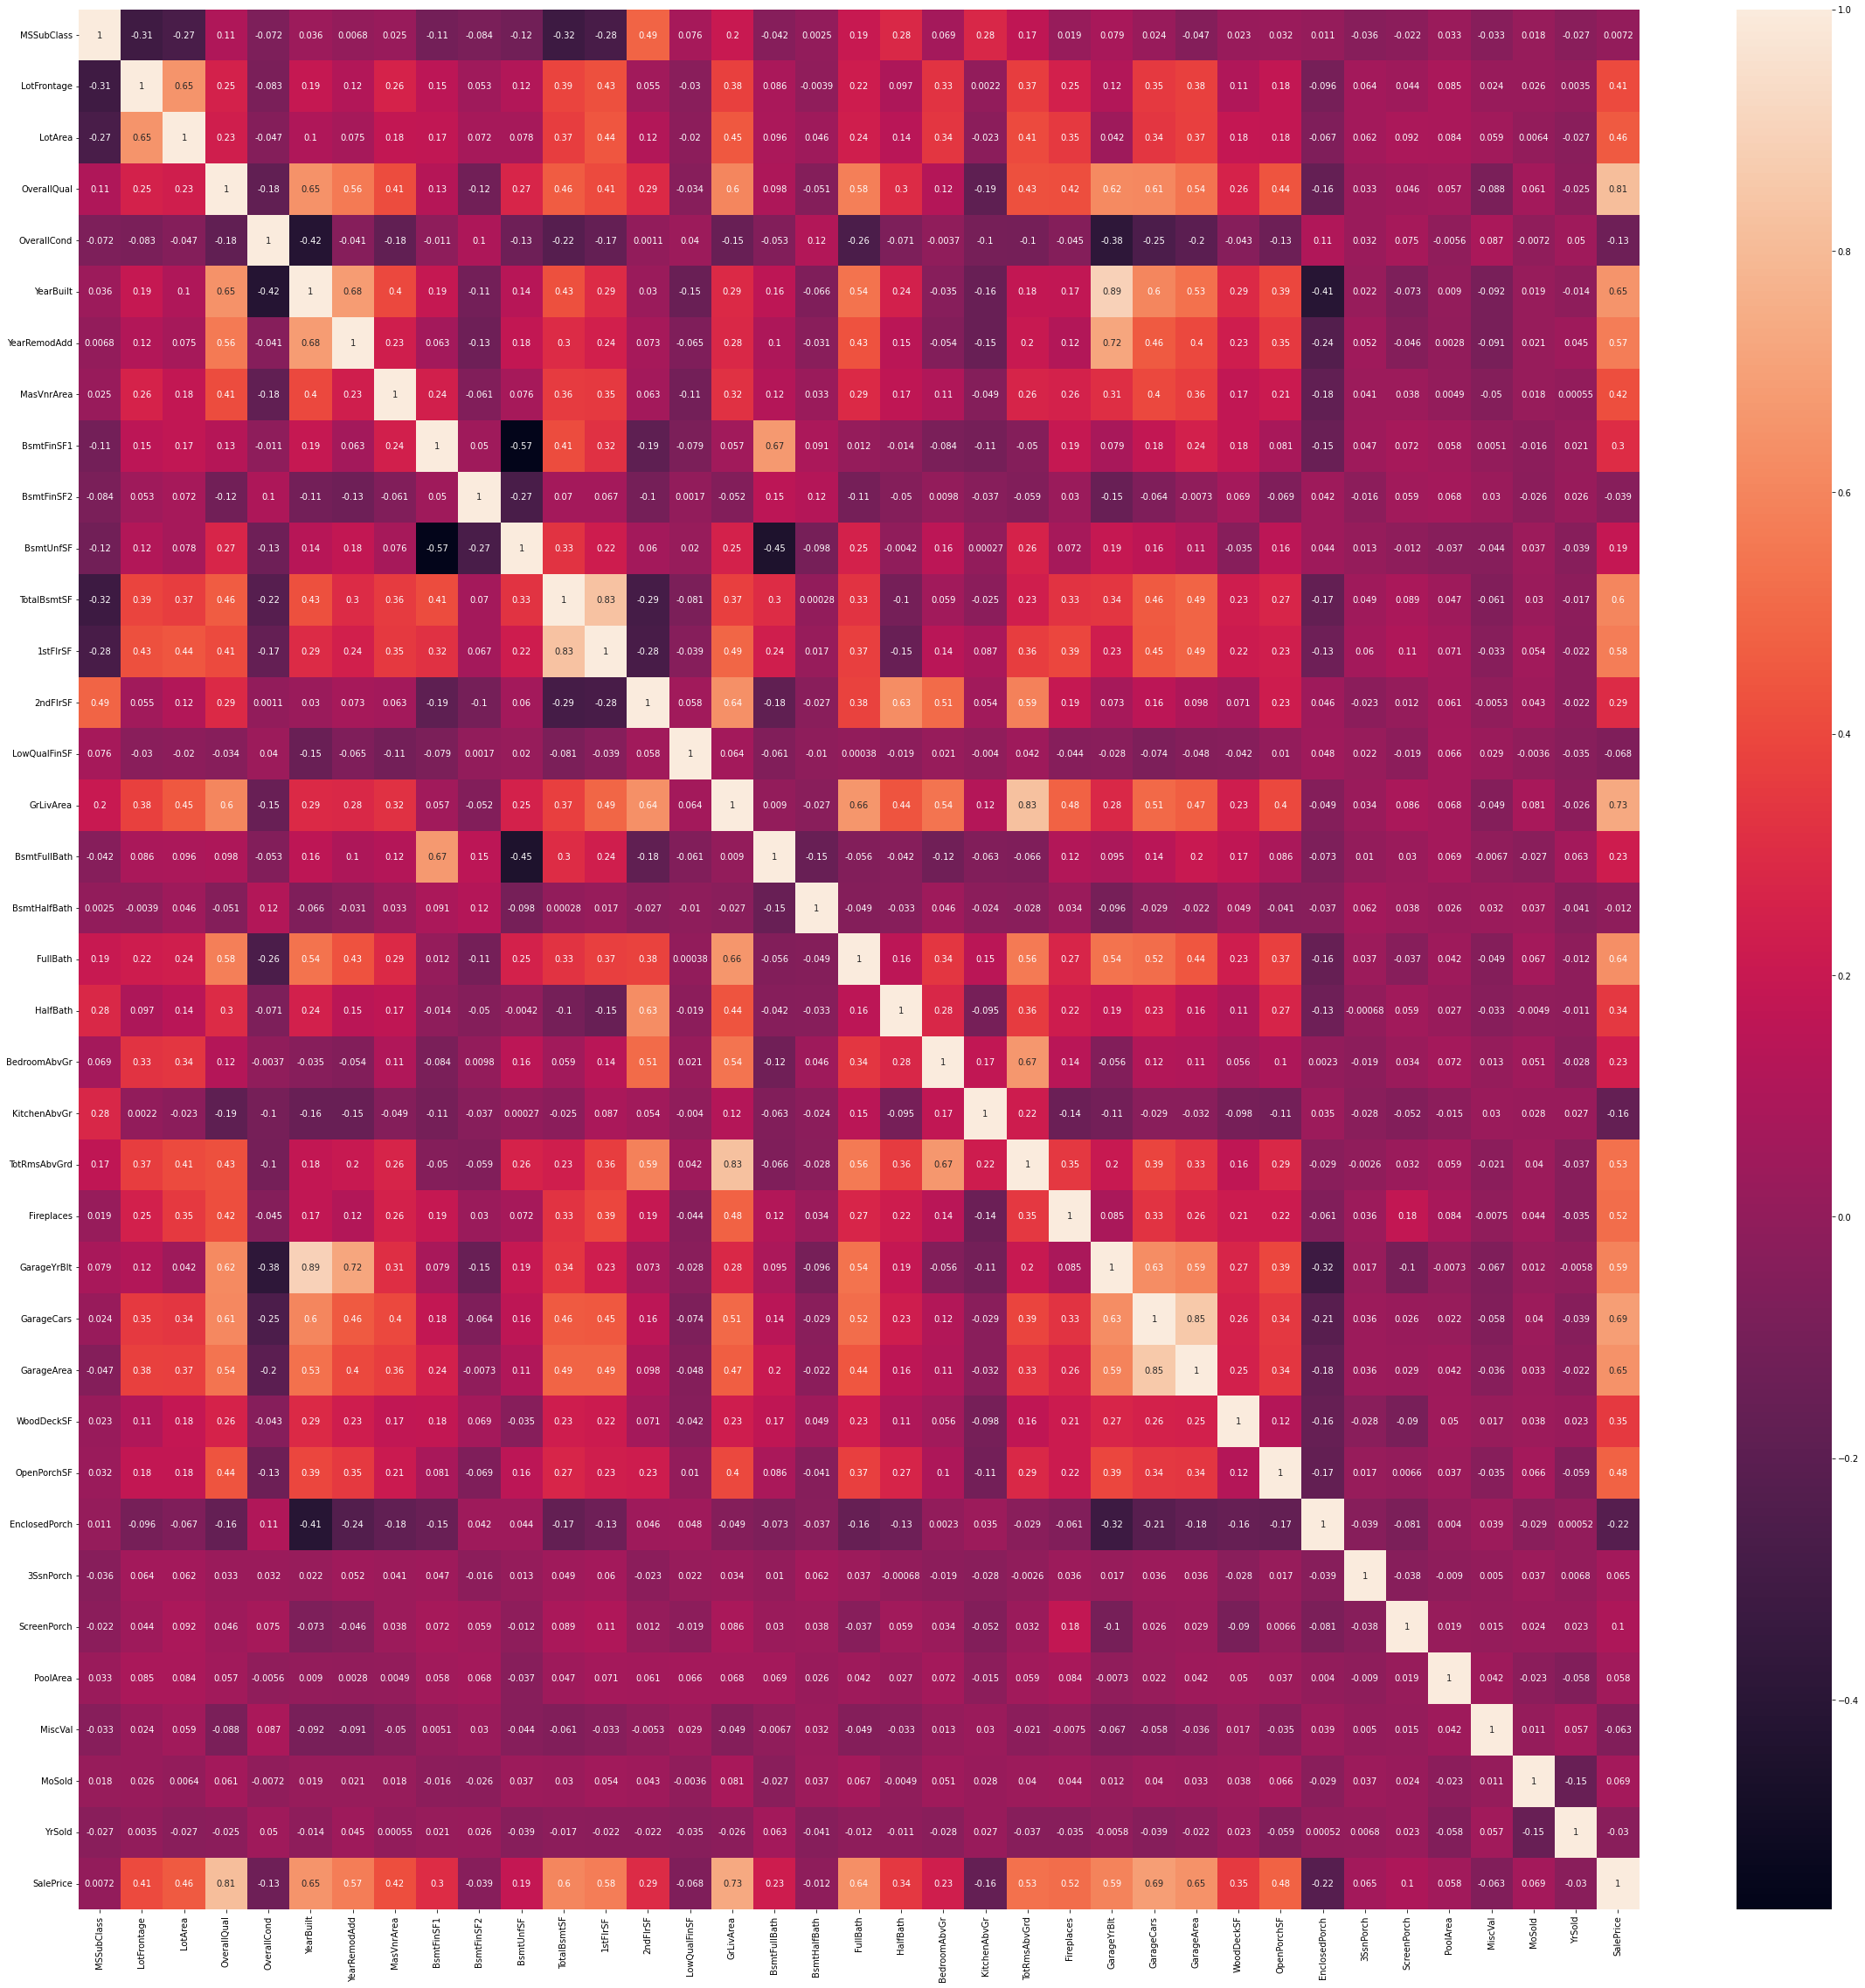

In [18]:
plt.figure(figsize=(40,40))

corr = train.corr(method = 'spearman')

sns.heatmap(corr, annot = True)

plt.show()

So as we can see here, there are plenty of interesting relationship here ! And compared to the pearson correlation, spearman is not only working on linear relationship.

Indeed the fundamental difference between the two correlation coefficients is that the Pearson coefficient works with a linear relationship between the two variables whereas the Spearman Coefficient works with monotonic relationships as well.

So regarding the interaction, we have for example some logic ones as for example interactions between GarageYblt and Yearbuilt (as it seems logic thath Garage was built at the same time as the garage), we also have the GarageCars and the GarageArea.

## Categorical features :

It could be also interesting to use ANOVA test to check the influence of categorical variable on SalePrice. Indeed, the lower is our p-value, the higher the impact of the categorical value is. Indeed in this case, it means, that the mean between the different categories is not the same.

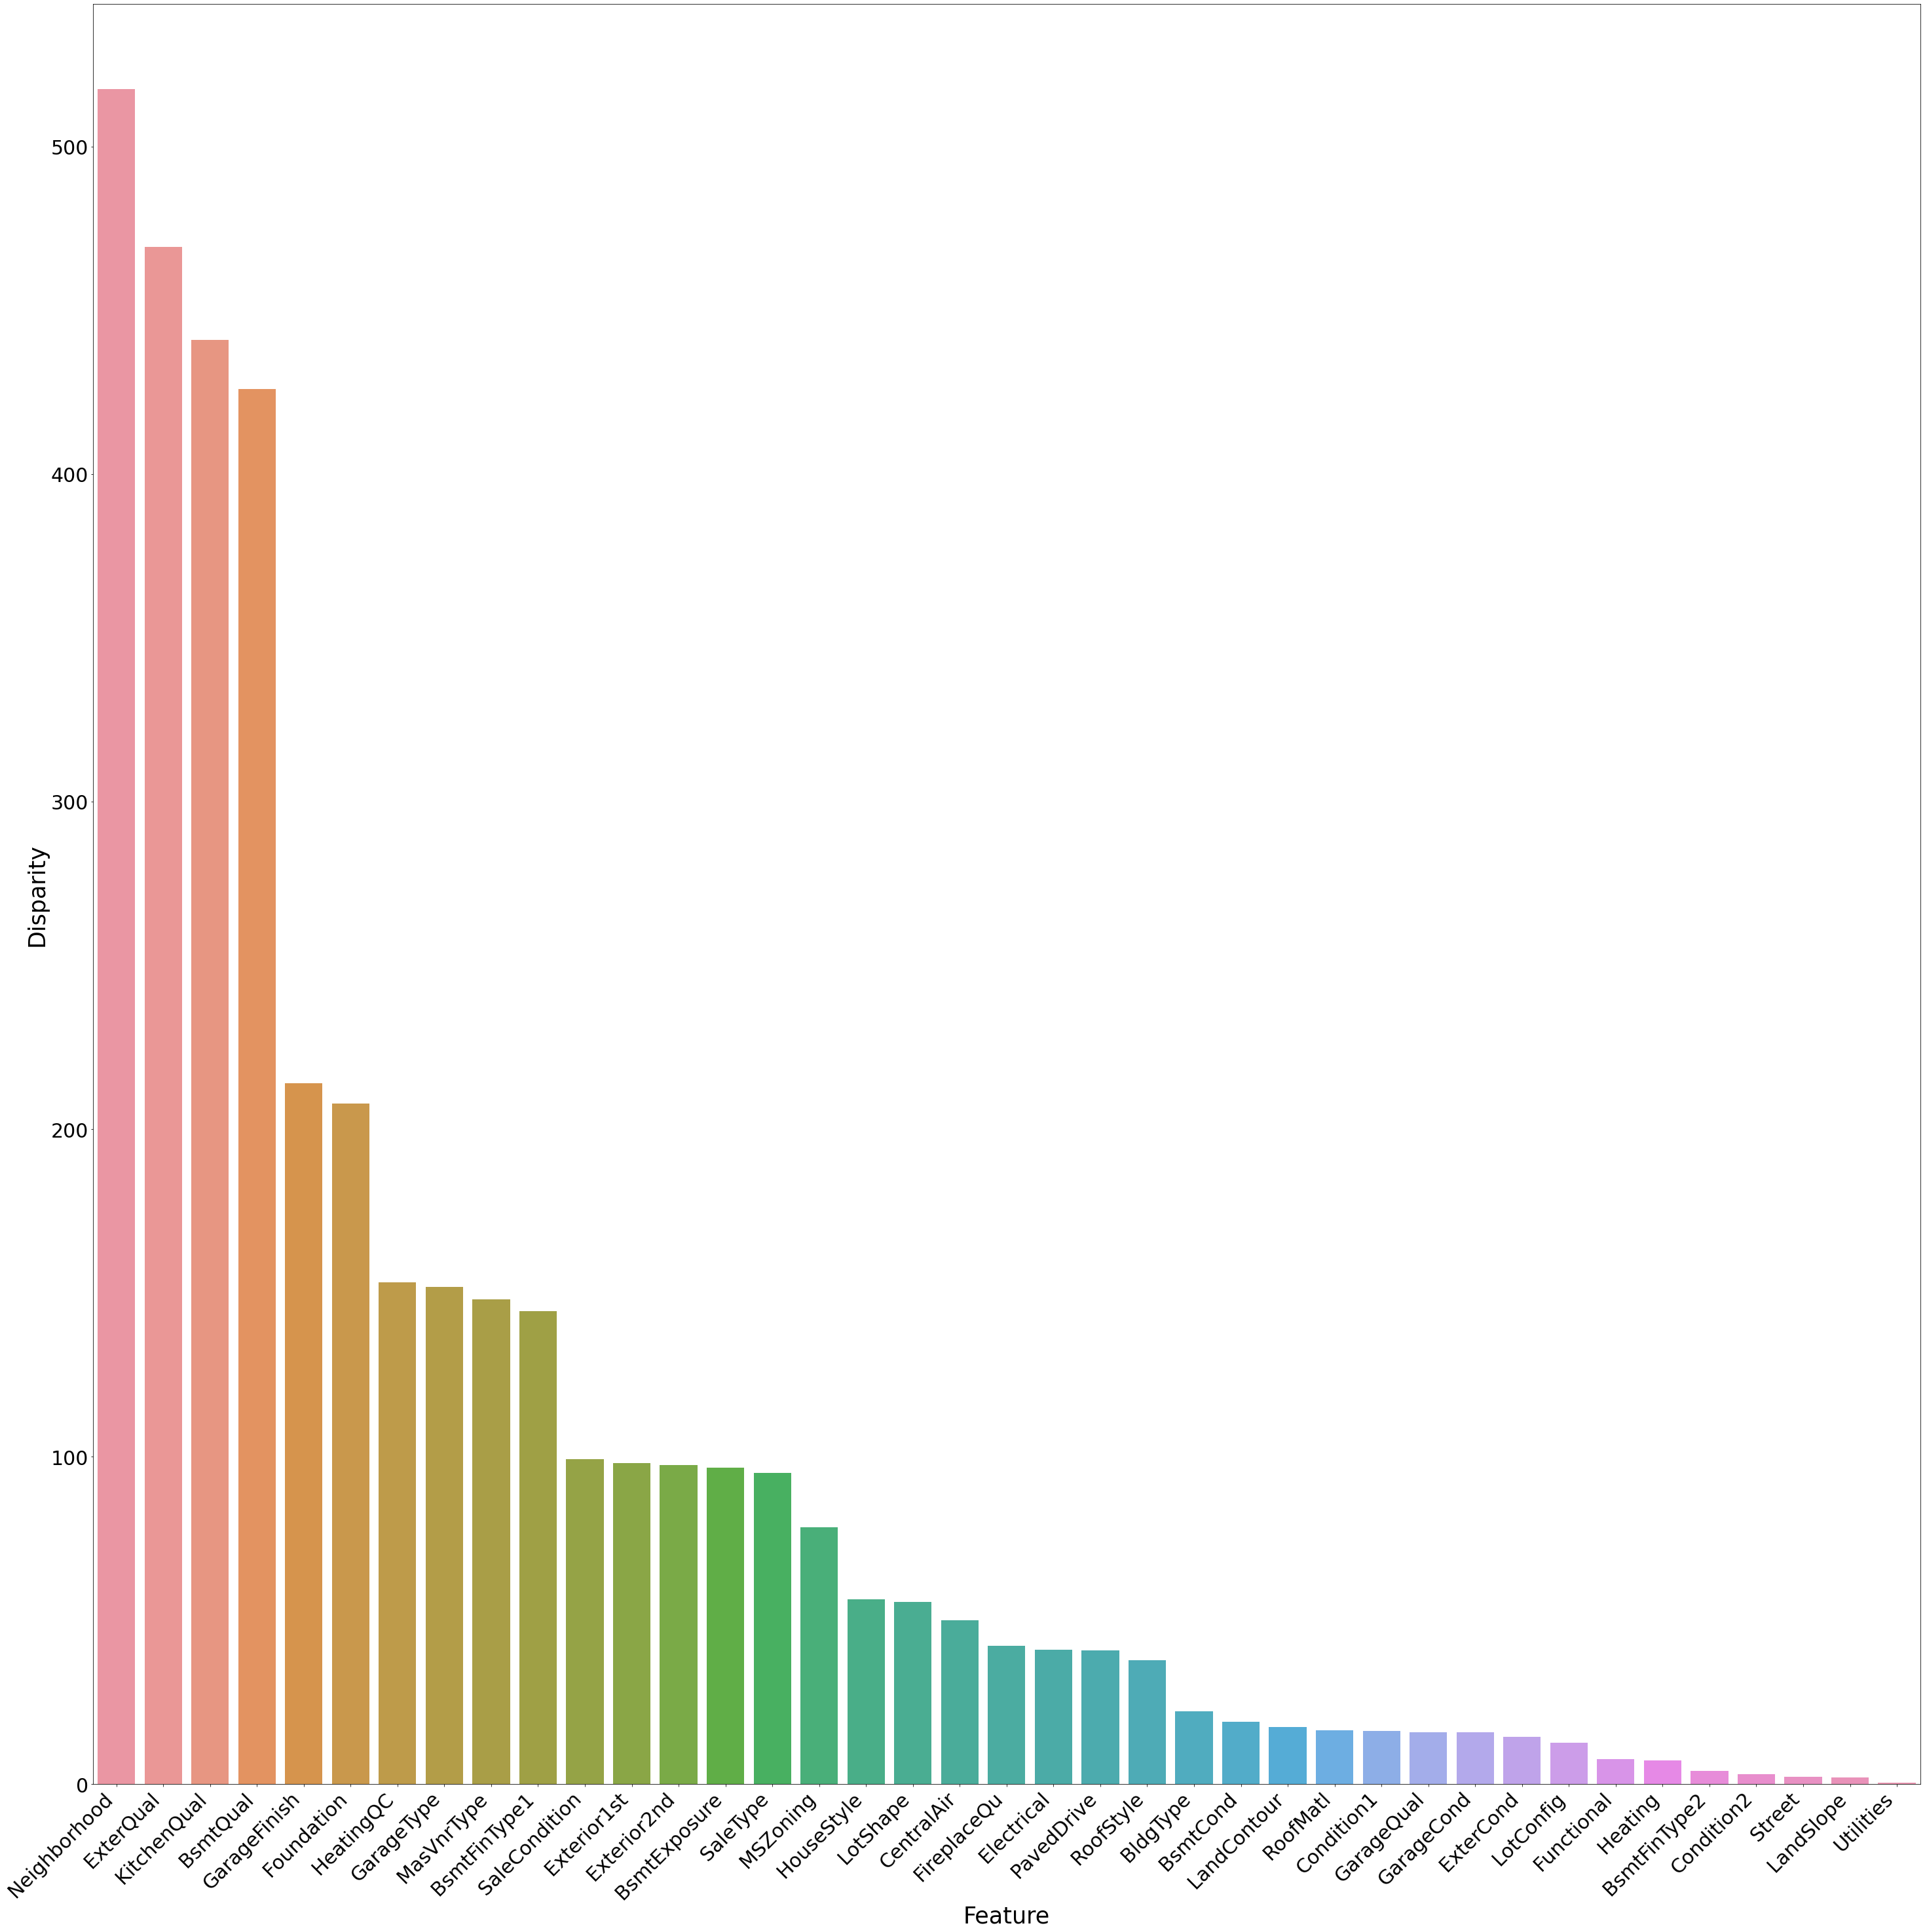

In [19]:
figure,ax=plt.subplots(1,1,figsize=(50,50))
disp=[]
for c in train.select_dtypes('object'):
        samples = []
        df=train[[c,"SalePrice"]].dropna(axis=0)
        for cls in df[c].unique():
            s = df[df[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        disp.append((c,np.log(1./pval)))

disparity=pd.DataFrame(disp,columns=["Feature","Disparity"]).sort_values(by=["Disparity"],ascending=False)
sns.barplot(data=disparity, x='Feature', y='Disparity')
ax.set_xticklabels(disparity['Feature'].values, rotation=45, ha='right',fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel('Feature', fontsize=35)
plt.ylabel('Disparity', fontsize=35)
plt.show()

In [20]:
missing = train.isnull().sum()
missing = missing[missing > 400]
missing.sort_values(inplace = True)
print(missing)

FireplaceQu    690
dtype: int64


In [21]:
c = missing.index
np.array(c)

array(['FireplaceQu'], dtype=object)

In [22]:
dftrain = train.drop(columns = c, axis = 1)
dftrain

MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0             60       RL         65.0     8450   Pave      Reg         Lvl   
1             20       RL         80.0     9600   Pave      Reg         Lvl   
2             60       RL         68.0    11250   Pave      IR1         Lvl   
3             70       RL         60.0     9550   Pave      IR1         Lvl   
4             60       RL         84.0    14260   Pave      IR1         Lvl   
...          ...      ...          ...      ...    ...      ...         ...   
1455          60       RL         62.0     7917   Pave      Reg         Lvl   
1456          20       RL         85.0    13175   Pave      Reg         Lvl   
1457          70       RL         66.0     9042   Pave      Reg         Lvl   
1458          20       RL         68.0     9717   Pave      Reg         Lvl   
1459          20       RL         75.0     9937   Pave      Reg         Lvl   

     Utilities LotConfig LandSlope  ... EnclosedPorch 3SsnPorch ScreenPorch  \
0       AllPub    Inside       Gtl  ...             0         0           0   
1       AllPub       FR2       Gtl  ...             0         0           0   
2       AllPub    Inside       Gtl  ...             0         0           0   
3       AllPub    Corner       Gtl  ...           272         0           0   
4       AllPub       FR2       Gtl  ...             0         0           0   
...        ...       ...       ...  ...           ...       ...         ...   
1455    AllPub    Inside       Gtl  ...             0         0           0   
1456    AllPub    Inside       Gtl  ...             0         0           0   
1457    AllPub    Inside       Gtl  ...             0         0           0   
1458    AllPub    Inside       Gtl  ...           112         0           0   
1459    AllPub    Inside       Gtl  ...             0         0           0   

     PoolArea MiscVal  MoSold  YrSold  SaleType  SaleCondition SalePrice  
0           0       0       2    2008        WD         Normal    208500  
1           0       0       5    2007        WD         Normal    181500  
2           0       0       9    2008        WD         Normal    223500  
3           0       0       2    2006        WD        Abnorml    140000  
4           0       0      12    2008        WD         Normal    250000  
...       ...     ...     ...     ...       ...            ...       ...  
1455        0       0       8    2007        WD         Normal    175000  
1456        0       0       2    2010        WD         Normal    210000  
1457        0    2500       5    2010        WD         Normal    266500  
1458        0       0       4    2010        WD         Normal    142125  
1459        0       0       6    2008        WD         Normal    147500  

[1460 rows x 75 columns]

In [23]:
zeros = dftrain.replace(0, np.nan)
zeros = zeros.isna().sum()
zeros = zeros[zeros > 300]
zeros.sort_values(inplace = True)
print(zeros)

BsmtFinSF1        467
OpenPorchSF       656
Fireplaces        690
WoodDeckSF        761
2ndFlrSF          829
BsmtFullBath      856
MasVnrArea        869
HalfBath          913
EnclosedPorch    1252
BsmtFinSF2       1293
ScreenPorch      1344
BsmtHalfBath     1378
MiscVal          1408
LowQualFinSF     1434
3SsnPorch        1436
PoolArea         1453
dtype: int64


In [24]:
c = zeros.index
np.array(c)

array(['BsmtFinSF1', 'OpenPorchSF', 'Fireplaces', 'WoodDeckSF',
       '2ndFlrSF', 'BsmtFullBath', 'MasVnrArea', 'HalfBath',
       'EnclosedPorch', 'BsmtFinSF2', 'ScreenPorch', 'BsmtHalfBath',
       'MiscVal', 'LowQualFinSF', '3SsnPorch', 'PoolArea'], dtype=object)

In [25]:
dftrain.drop(columns = c, axis = 1)

MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0             60       RL         65.0     8450   Pave      Reg         Lvl   
1             20       RL         80.0     9600   Pave      Reg         Lvl   
2             60       RL         68.0    11250   Pave      IR1         Lvl   
3             70       RL         60.0     9550   Pave      IR1         Lvl   
4             60       RL         84.0    14260   Pave      IR1         Lvl   
...          ...      ...          ...      ...    ...      ...         ...   
1455          60       RL         62.0     7917   Pave      Reg         Lvl   
1456          20       RL         85.0    13175   Pave      Reg         Lvl   
1457          70       RL         66.0     9042   Pave      Reg         Lvl   
1458          20       RL         68.0     9717   Pave      Reg         Lvl   
1459          20       RL         75.0     9937   Pave      Reg         Lvl   

     Utilities LotConfig LandSlope  ... GarageCars GarageArea GarageQual  \
0       AllPub    Inside       Gtl  ...          2        548         TA   
1       AllPub       FR2       Gtl  ...          2        460         TA   
2       AllPub    Inside       Gtl  ...          2        608         TA   
3       AllPub    Corner       Gtl  ...          3        642         TA   
4       AllPub       FR2       Gtl  ...          3        836         TA   
...        ...       ...       ...  ...        ...        ...        ...   
1455    AllPub    Inside       Gtl  ...          2        460         TA   
1456    AllPub    Inside       Gtl  ...          2        500         TA   
1457    AllPub    Inside       Gtl  ...          1        252         TA   
1458    AllPub    Inside       Gtl  ...          1        240         TA   
1459    AllPub    Inside       Gtl  ...          1        276         TA   

     GarageCond PavedDrive  MoSold  YrSold  SaleType  SaleCondition SalePrice  
0            TA          Y       2    2008        WD         Normal    208500  
1            TA          Y       5    2007        WD         Normal    181500  
2            TA          Y       9    2008        WD         Normal    223500  
3            TA          Y       2    2006        WD        Abnorml    140000  
4            TA          Y      12    2008        WD         Normal    250000  
...         ...        ...     ...     ...       ...            ...       ...  
1455         TA          Y       8    2007        WD         Normal    175000  
1456         TA          Y       2    2010        WD         Normal    210000  
1457         TA          Y       5    2010        WD         Normal    266500  
1458         TA          Y       4    2010        WD         Normal    142125  
1459         TA          Y       6    2008        WD         Normal    147500  

[1460 rows x 59 columns]

# Feature selection

Find columns with high correlation to the outcome 'Sale Price' 

<AxesSubplot:>

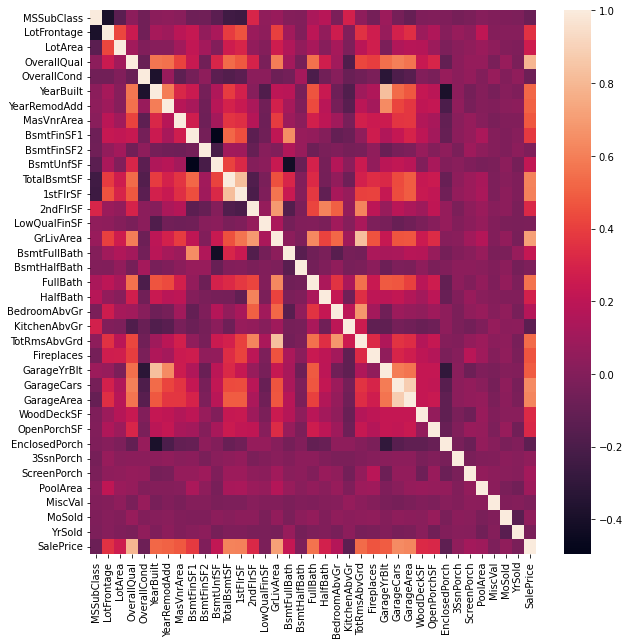

In [26]:
plt.figure(figsize=(10,10))
sns.heatmap(dftrain.corr())

In [27]:
important_num_cols = list(dftrain.corr()
                        ["SalePrice"][(dftrain.corr()["SalePrice"]>0.40) 
                        |
                        (dftrain.corr()["SalePrice"]<-0.40)].index)
important_num_cols

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'SalePrice']

<AxesSubplot:>

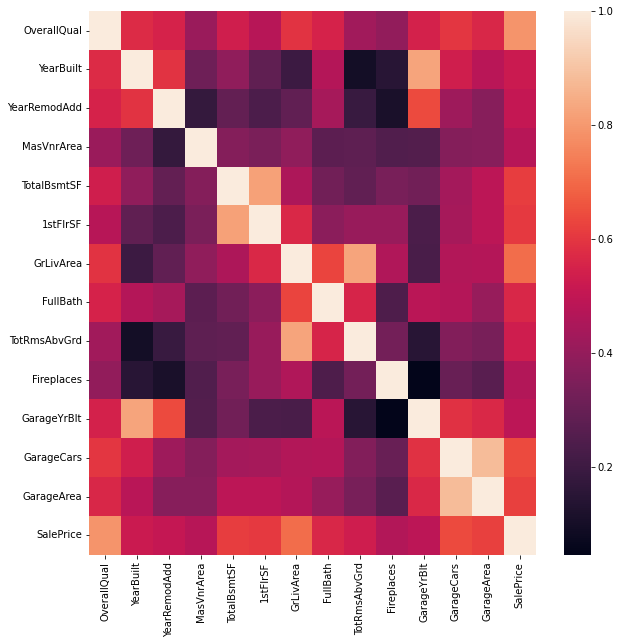

In [28]:
numcols = dftrain[dftrain.columns.intersection(important_num_cols)]
plt.figure(figsize=(10,10))
sns.heatmap(numcols.corr())

In [29]:
c = ['1stFlrSF', 'GarageCars', 'TotRmsAbvGrd', 'GarageYrBlt', 'YearRemodAdd']
numcols = numcols.drop(columns = c, axis = 1)
numcols

OverallQual  YearBuilt  MasVnrArea  TotalBsmtSF  GrLivArea  FullBath  \
0               7       2003       196.0          856       1710         2   
1               6       1976         0.0         1262       1262         2   
2               7       2001       162.0          920       1786         2   
3               7       1915         0.0          756       1717         1   
4               8       2000       350.0         1145       2198         2   
...           ...        ...         ...          ...        ...       ...   
1455            6       1999         0.0          953       1647         2   
1456            6       1978       119.0         1542       2073         2   
1457            7       1941         0.0         1152       2340         2   
1458            5       1950         0.0         1078       1078         1   
1459            5       1965         0.0         1256       1256         1   

      Fireplaces  GarageArea  SalePrice  
0              0         548     208500  
1              1         460     181500  
2              1         608     223500  
3              1         642     140000  
4              1         836     250000  
...          ...         ...        ...  
1455           1         460     175000  
1456           2         500     210000  
1457           2         252     266500  
1458           0         240     142125  
1459           0         276     147500  

[1460 rows x 9 columns]

In [30]:
X = numcols.drop("SalePrice",axis=1)
y = numcols["SalePrice"]

In [31]:
X = X.fillna(0)

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X)

In [33]:
from sklearn.model_selection import train_test_split,cross_val_score
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [34]:
!pip install Auto-sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
import autosklearn.regression

In [36]:
TIME_BUDGET=60
automl = autosklearn.regression.AutoSklearnRegressor(
time_left_for_this_task=TIME_BUDGET,
n_jobs=-1
)
automl.fit(X_train, y_train, dataset_name='house price prediction')
y_pred = automl.predict(X_test)
score=r2_score(y_test, y_pred)
print(score)

0.8748870378622174


In [37]:
data = pd.DataFrame({"Y_test": y_test , "Y_pred" : y_pred})
data

Y_test         Y_pred
892   154500  137413.574219
1105  325000  328953.070312
413   115000  116440.097656
522   159000  171193.125000
1036  315500  305104.765625
...      ...            ...
479    89471  125751.351562
1361  260000  219176.632812
802   189000  182690.605469
651   108000  131428.240234
722   124500  116011.693359

[292 rows x 2 columns]

# Test Dataset

In [38]:
missing = test.isnull().sum()
missing = missing[missing > 400]
missing.sort_values(inplace = True)
print(missing)

FireplaceQu     730
Fence          1169
Alley          1352
MiscFeature    1408
PoolQC         1456
dtype: int64


In [39]:
test

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0     1461          20       RH         80.0    11622   Pave   NaN      Reg   
1     1462          20       RL         81.0    14267   Pave   NaN      IR1   
2     1463          60       RL         74.0    13830   Pave   NaN      IR1   
3     1464          60       RL         78.0     9978   Pave   NaN      IR1   
4     1465         120       RL         43.0     5005   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1454  2915         160       RM         21.0     1936   Pave   NaN      Reg   
1455  2916         160       RM         21.0     1894   Pave   NaN      Reg   
1456  2917          20       RL        160.0    20000   Pave   NaN      Reg   
1457  2918          85       RL         62.0    10441   Pave   NaN      Reg   
1458  2919          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence  \
0            Lvl    AllPub  ...         120        0    NaN  MnPrv   
1            Lvl    AllPub  ...           0        0    NaN    NaN   
2            Lvl    AllPub  ...           0        0    NaN  MnPrv   
3            Lvl    AllPub  ...           0        0    NaN    NaN   
4            HLS    AllPub  ...         144        0    NaN    NaN   
...          ...       ...  ...         ...      ...    ...    ...   
1454         Lvl    AllPub  ...           0        0    NaN    NaN   
1455         Lvl    AllPub  ...           0        0    NaN    NaN   
1456         Lvl    AllPub  ...           0        0    NaN    NaN   
1457         Lvl    AllPub  ...           0        0    NaN  MnPrv   
1458         Lvl    AllPub  ...           0        0    NaN    NaN   

     MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  
0            NaN       0      6    2010        WD         Normal  
1           Gar2   12500      6    2010        WD         Normal  
2            NaN       0      3    2010        WD         Normal  
3            NaN       0      6    2010        WD         Normal  
4            NaN       0      1    2010        WD         Normal  
...          ...     ...    ...     ...       ...            ...  
1454         NaN       0      6    2006        WD         Normal  
1455         NaN       0      4    2006        WD        Abnorml  
1456         NaN       0      9    2006        WD        Abnorml  
1457        Shed     700      7    2006        WD         Normal  
1458         NaN       0     11    2006        WD         Normal  

[1459 rows x 80 columns]

In [40]:
zeros = test.replace(0, np.nan)
zeros = zeros.isna().sum()
zeros = zeros[zeros > 300]
zeros.sort_values(inplace = True)
print(zeros)

BsmtFinSF1        463
OpenPorchSF       642
FireplaceQu       730
Fireplaces        730
WoodDeckSF        762
2ndFlrSF          839
BsmtFullBath      851
MasVnrArea        892
HalfBath          921
Fence            1169
EnclosedPorch    1208
BsmtFinSF2       1279
ScreenPorch      1319
Alley            1352
BsmtHalfBath     1366
MiscFeature      1408
MiscVal          1408
LowQualFinSF     1445
3SsnPorch        1446
PoolArea         1453
PoolQC           1456
dtype: int64


In [41]:
c = zeros.index
np.array(c)

array(['BsmtFinSF1', 'OpenPorchSF', 'FireplaceQu', 'Fireplaces',
       'WoodDeckSF', '2ndFlrSF', 'BsmtFullBath', 'MasVnrArea', 'HalfBath',
       'Fence', 'EnclosedPorch', 'BsmtFinSF2', 'ScreenPorch', 'Alley',
       'BsmtHalfBath', 'MiscFeature', 'MiscVal', 'LowQualFinSF',
       '3SsnPorch', 'PoolArea', 'PoolQC'], dtype=object)

In [42]:
test.drop(columns = c, axis = 1)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape  \
0     1461          20       RH         80.0    11622   Pave      Reg   
1     1462          20       RL         81.0    14267   Pave      IR1   
2     1463          60       RL         74.0    13830   Pave      IR1   
3     1464          60       RL         78.0     9978   Pave      IR1   
4     1465         120       RL         43.0     5005   Pave      IR1   
...    ...         ...      ...          ...      ...    ...      ...   
1454  2915         160       RM         21.0     1936   Pave      Reg   
1455  2916         160       RM         21.0     1894   Pave      Reg   
1456  2917          20       RL        160.0    20000   Pave      Reg   
1457  2918          85       RL         62.0    10441   Pave      Reg   
1458  2919          60       RL         74.0     9627   Pave      Reg   

     LandContour Utilities LotConfig  ... GarageFinish GarageCars GarageArea  \
0            Lvl    AllPub    Inside  ...          Unf        1.0      730.0   
1            Lvl    AllPub    Corner  ...          Unf        1.0      312.0   
2            Lvl    AllPub    Inside  ...          Fin        2.0      482.0   
3            Lvl    AllPub    Inside  ...          Fin        2.0      470.0   
4            HLS    AllPub    Inside  ...          RFn        2.0      506.0   
...          ...       ...       ...  ...          ...        ...        ...   
1454         Lvl    AllPub    Inside  ...          NaN        0.0        0.0   
1455         Lvl    AllPub    Inside  ...          Unf        1.0      286.0   
1456         Lvl    AllPub    Inside  ...          Unf        2.0      576.0   
1457         Lvl    AllPub    Inside  ...          NaN        0.0        0.0   
1458         Lvl    AllPub    Inside  ...          Fin        3.0      650.0   

     GarageQual GarageCond PavedDrive  MoSold  YrSold  SaleType  SaleCondition  
0            TA         TA          Y       6    2010        WD         Normal  
1            TA         TA          Y       6    2010        WD         Normal  
2            TA         TA          Y       3    2010        WD         Normal  
3            TA         TA          Y       6    2010        WD         Normal  
4            TA         TA          Y       1    2010        WD         Normal  
...         ...        ...        ...     ...     ...       ...            ...  
1454        NaN        NaN          Y       6    2006        WD         Normal  
1455         TA         TA          Y       4    2006        WD        Abnorml  
1456         TA         TA          Y       9    2006        WD        Abnorml  
1457        NaN        NaN          Y       7    2006        WD         Normal  
1458         TA         TA          Y      11    2006        WD         Normal  

[1459 rows x 59 columns]

In [43]:
test1 = test[['OverallQual', 'YearBuilt', 'MasVnrArea', 'TotalBsmtSF', 'GrLivArea','FullBath', 'Fireplaces', 'GarageArea']]

In [44]:
test1

OverallQual  YearBuilt  MasVnrArea  TotalBsmtSF  GrLivArea  FullBath  \
0               5       1961         0.0        882.0        896         1   
1               6       1958       108.0       1329.0       1329         1   
2               5       1997         0.0        928.0       1629         2   
3               6       1998        20.0        926.0       1604         2   
4               8       1992         0.0       1280.0       1280         2   
...           ...        ...         ...          ...        ...       ...   
1454            4       1970         0.0        546.0       1092         1   
1455            4       1970         0.0        546.0       1092         1   
1456            5       1960         0.0       1224.0       1224         1   
1457            5       1992         0.0        912.0        970         1   
1458            7       1993        94.0        996.0       2000         2   

      Fireplaces  GarageArea  
0              0       730.0  
1              0       312.0  
2              1       482.0  
3              1       470.0  
4              0       506.0  
...          ...         ...  
1454           0         0.0  
1455           0       286.0  
1456           1       576.0  
1457           0         0.0  
1458           1       650.0  

[1459 rows x 8 columns]

In [45]:
X1 = test1.fillna(0)

In [46]:
X1 = scaler.fit_transform(X1)
new_test = pd.DataFrame(X1)

In [47]:
new_y_pred = automl.predict(new_test)

In [48]:
new_y_pred

array([126289.125     , 147260.1328125 , 173193.87109375, ...,
       146843.72265625, 106974.65429688, 223090.421875  ])

In [49]:
ypred = list(new_y_pred)

In [50]:
id_list = list(test_c['Id'])

In [51]:
final = pd.DataFrame([id_list,ypred]).T

In [52]:
final

0              1
0     1461.0  126289.125000
1     1462.0  147260.132812
2     1463.0  173193.871094
3     1464.0  177755.023438
4     1465.0  208417.660156
...      ...            ...
1454  2915.0   94325.728516
1455  2916.0  100841.789062
1456  2917.0  146843.722656
1457  2918.0  106974.654297
1458  2919.0  223090.421875

[1459 rows x 2 columns]

In [53]:
final.columns=['Id','SalePrice']
final = final.astype(int)

In [54]:
final

Id  SalePrice
0     1461     126289
1     1462     147260
2     1463     173193
3     1464     177755
4     1465     208417
...    ...        ...
1454  2915      94325
1455  2916     100841
1456  2917     146843
1457  2918     106974
1458  2919     223090

[1459 rows x 2 columns]

## save to CSV

In [55]:
final.to_csv("submit.csv",index=False)